# Image Segmentation of Bacteria Cells and Fold Change Prediction using Least Square Regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# working with filenames
import glob

# image processing
import skimage.io
import skimage.exposure
import skimage.measure

# csv work, parsing tablular data
import pandas as pd

# least-squares regression, nonlinear fits and optimizations
import scipy.optimize
import math

## Question 1b

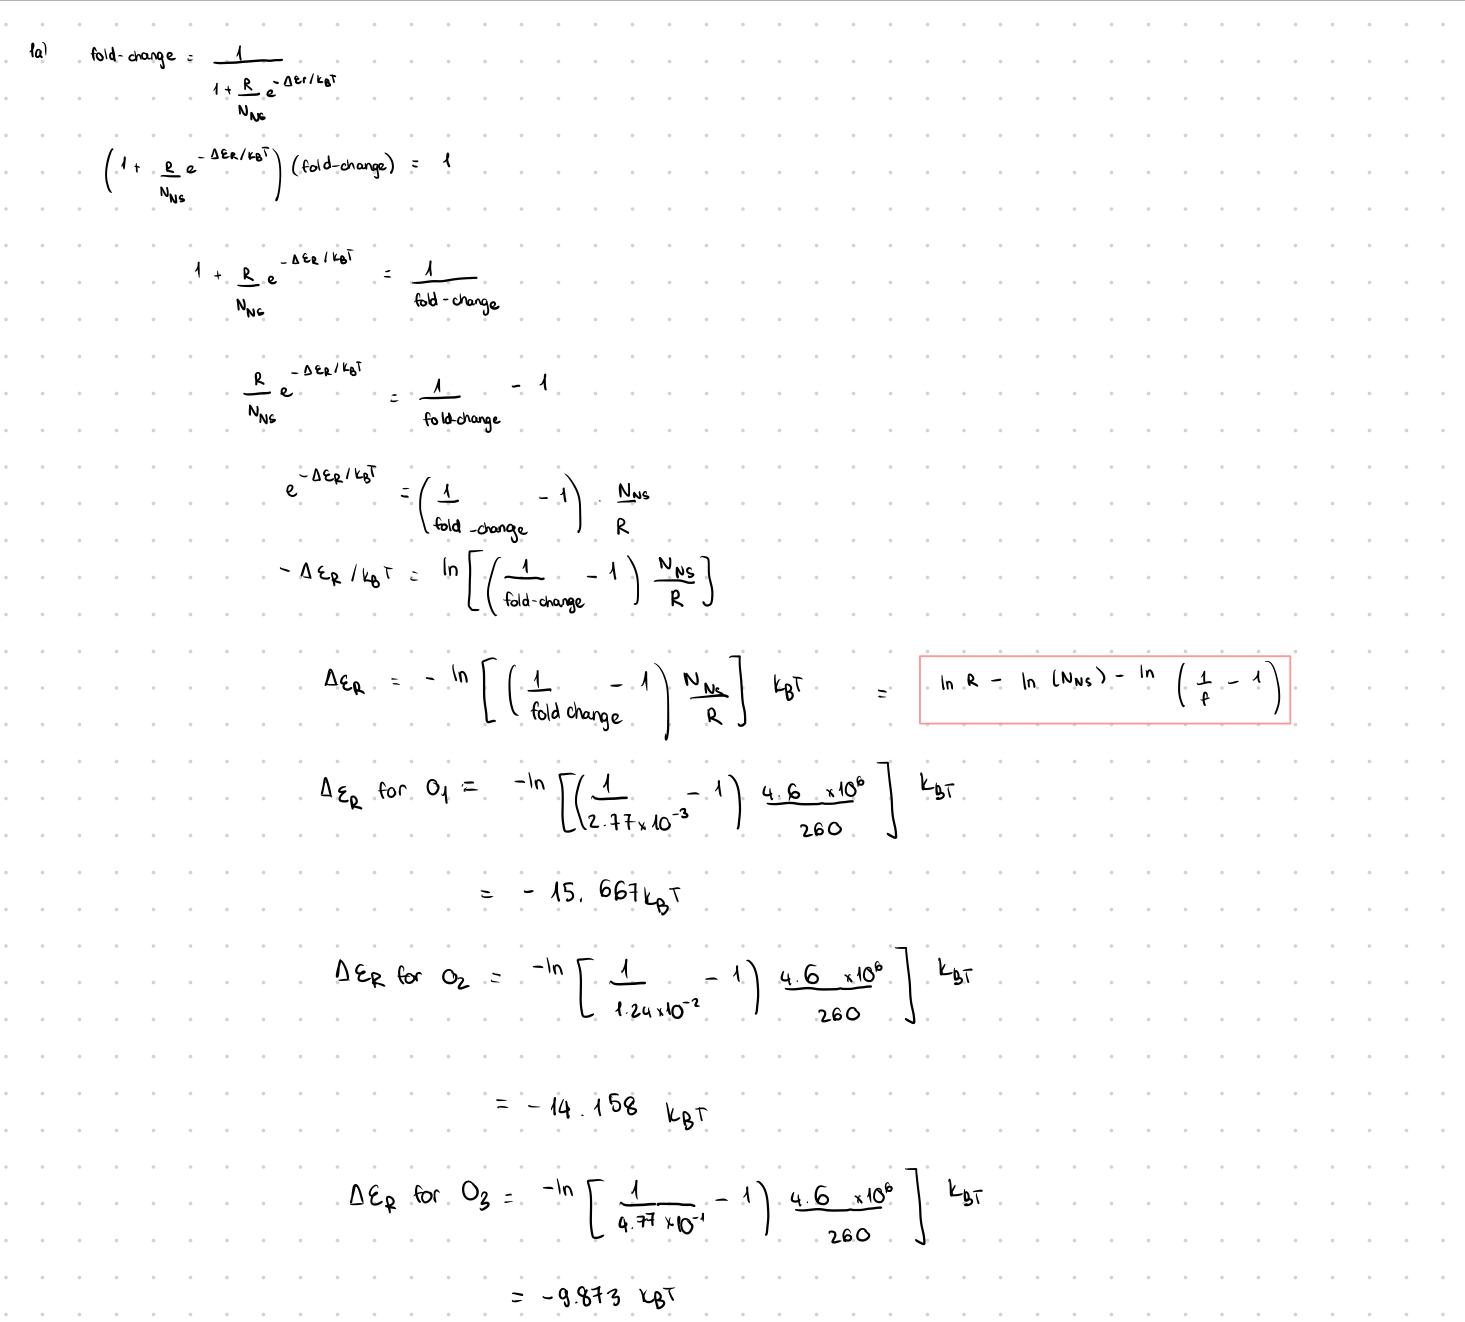

From 1a, I get an expression relating the difference in energy
between having a repressor bound to its target site and having it bound to any
random sequence in the genome, Δϵr, with the fold change. Using the formula and the list of strains and their respective operators in table 1, I can solve for the values of Δϵr in units of kBT.

With these three values of Δϵr, I will plot the fold change predictions for each operator sequence. I will use matplotlib's plot function to plot the fold change predictions as a function of the repressor copy number R ranging from 1 to 1000. I set the scale of both the x and y axis to be log-based to normalize skewed data. I also include the data points calculated from table 1 using the plt.scatter() function. 

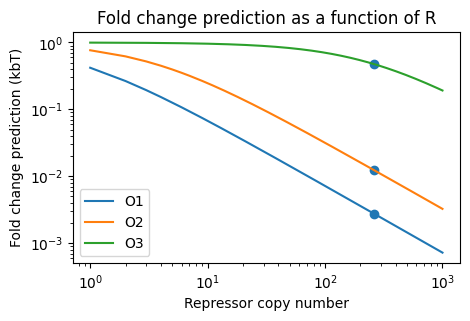

In [ ]:
def plot_fold_change():
  """
  Plot fold change prediction based on operator
  """
  #E coli genome size
  N_ns = 4.6 * 10**6

  #binding energy difference calculated by hand attached above
  delta_er_O1 = -15.667
  delta_er_O2 = -14.158
  delta_er_O3 = -9.873

  #set up plot and x axis range
  R = np.arange(1, 1001)
  fig, ax = plt.subplots(figsize = (5, 3))
  
  #set up y relationship with x
  fold_change_1 = 1.0 / (1 + (R / N_ns)* math.exp(-1 *  delta_er_O1))
  fold_change_2 = 1.0 / (1 + (R / N_ns)* math.exp(-1 * delta_er_O2 ))
  fold_change_3= 1.0 / (1 + (R / N_ns)* math.exp(-1 * delta_er_O3))

  #plot three fold change predictions for three operators
  plt.plot(R, fold_change_1)
  plt.plot(R, fold_change_2)
  plt.plot(R, fold_change_3)

  plt.xscale("log")
  plt.yscale("log")

  #set ticks on the axes
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  
  #plot the provided data points for each operator
  plt.scatter([260, 260, 260], [2.77*10**(-3), 1.24 *10**(-2), 4.77 * 10**(-1)])

  #Label axes and give plot a title
  plt.title("Fold change prediction as a function of R")
  plt.xlabel("Repressor copy number", fontsize=10)
  plt.ylabel("Fold change prediction (kbT)", fontsize=10)
  plt.legend(['O1','O2', 'O3'])


plot_fold_change()

## Question 1c



I will mount drive where I have uploaded the image files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


I will copy the file path to the directory and use the imread() function to load the image from a file. The image file is essentially a 2d-array of integers. These numbers are intensity values, which are correlated to the number of fluorophores present at the corresponding area in the specimen.

In [ ]:
image_dir = "/content/drive/MyDrive/Bi1/lacI_titration/"
image = skimage.io.imread(image_dir + "O1_delta_phase_pos_01.tif")

To make downstream processing easier, I will normalize the intensity values such that each value is between 0 and 1.

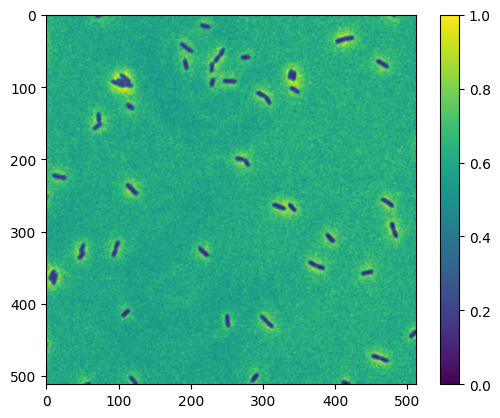

In [ ]:
im_normed = (image - image.min()) / (image.max() - image.min())
fig, ax = plt.subplots()
p = ax.imshow(im_normed)
ax.grid(False)
fig.colorbar(p);

Looking at the figure above, we see that the pixels corresponding to the cells largely have a normalized intensity value before 0.3. I will use this use this as a threshold to extract the pixels that correspond to a cell. 

I will use the insights above to write the segment_image function. First I will normalize the intensity values of pixels to values between 0 and 1 Next I will compare the intensity values to a phase threshold. I will label each of the individual cells using the label function in the skimage.measure module, which finds the regions of the 2d array that are connected and assign each connected region with an integer. Finally, I wiill use `approved_cells` to replot the image image such that I show the cells in bright cyan on top of the original image in grayscale. The RGB scale is calibrated so that when a color's three red/green/blue numbers are equal, the color is a shade of gray.

In [ ]:
def segment_im(im_phase, ip_dist=0.160, area_bounds=(1, 4),
                      phase_thresh=0.3, show_mask=False):
    #normalize intensity values to between 0 and 1
    im_normed = (im_phase - im_phase.min()) / (im_phase.max() - im_phase.min())
    #pixels corresponding to cells largely have a normalized intensity
    im_thresh = im_normed < phase_thresh

    im_lab, num_obj = skimage.measure.label(im_thresh, return_num=True)

    approved_cells = np.zeros_like(im_thresh)
    for i in range(num_obj):
        cell = (im_lab == i + 1)
        cell_area_px = np.sum(cell)
        cell_area = cell_area_px * ip_dist**2
        if (cell_area > area_bounds[0]) and (cell_area < area_bounds[1]):
            approved_cells += cell

    if show_mask:
        im_copy = np.copy(im_normed)
        im_copy[approved_cells] = 1.0
        im_rgb = np.dstack((im_normed, im_copy, im_copy))

        fig, ax = plt.subplots()
        ax.imshow(im_rgb)
        plt.show()

    return approved_cells

I will call the the segment_im function above on a list of image files. The cyan pixels are bacteria cells, and black is deemed not the cell from the upper bound filter. The mask on top of the image is shown in the printed result.


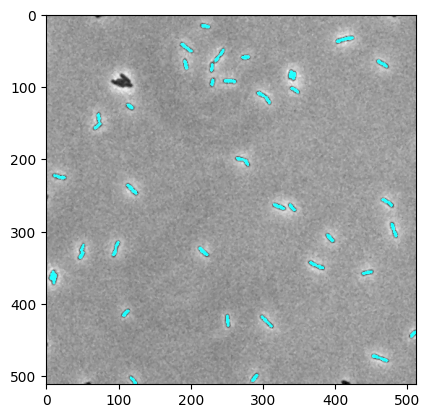

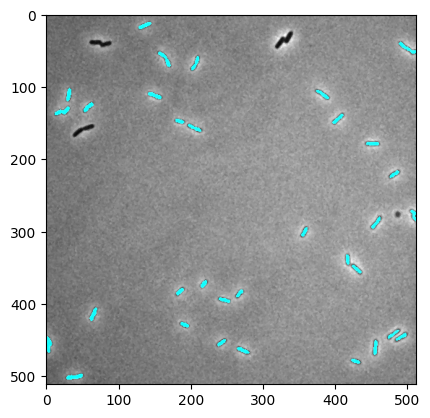

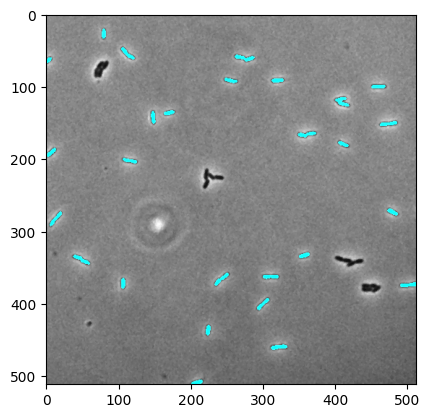

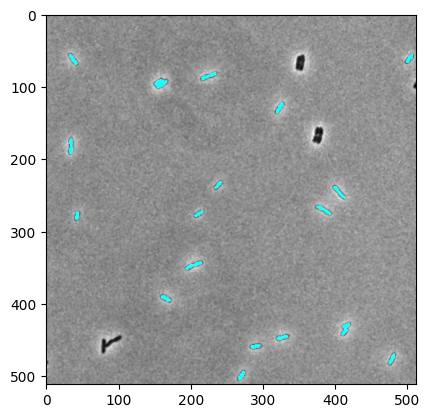

In [ ]:
images = ["O1_delta_phase_pos_01.tif","O2_delta_phase_pos_01.tif","O3_auto_phase_pos_01.tif", "O1_R60_phase_pos_01.tif"]
for i in range(len(images)):
  file_path = "/content/drive/MyDrive/Bi1/lacI_titration/" + str(images[i])
  image = skimage.io.imread(file_path)
  approved_cells = segment_im(image, ip_dist=0.160, area_bounds=(1, 4),
                      phase_thresh=0.3, show_mask=True)
  

## Question 1d

To extract the fluorescence level, I will use the code from 1c to segment the phase image, then use the mask to compute fluroescent intensities for the segmented cells. The function returns a list of total fluorescent intensities of segmented objects.

In [ ]:
def extract_intensities(im_phase, im_fluor):
    # find the cells
    im_mask = segment_im(im_phase)
    # relabel since segmentation mask is binary and we want to obtain the fluorescence level of each individual cell
    im_lab, num_cells = skimage.measure.label(im_mask, return_num=True)
    # storage for intensities. this time we know how many objects we have
    intensity_list = np.zeros(num_cells)
    # Loop over all cells im image
    for i in range(num_cells):
        # Slice out the cell of interest. off by 1 b/c 0 is bkgnd!
        cell = (im_lab == i + 1)
        # multiplication clears everything but i-th cell in im_fluor,
        # then sum gives total cell intensity
        tot_intensity = np.sum(cell * im_fluor)
        intensity_list[i] = tot_intensity
    return intensity_list

To make sure the extract_intensities function works, I will plot histograms of the values by passing in the phase contrast images and their corresponding fluorescence files. I see that the intensity values on average for the delta strains are higher than the intensity values for the auto strains, which is reasonable because the delta strains have 0 repressors and therefore more genes are expressed, leading to a higher level of fluorescence. On the other hand, the auto strains are where the fluorescent gene of interest is removed entirely, so there is only a low level of autofluorescence. For the O1_R60 strain, since the more repressors there are, the less the gene is expressed. Therefore, we see lower intensity values for the O1_R60 strain.

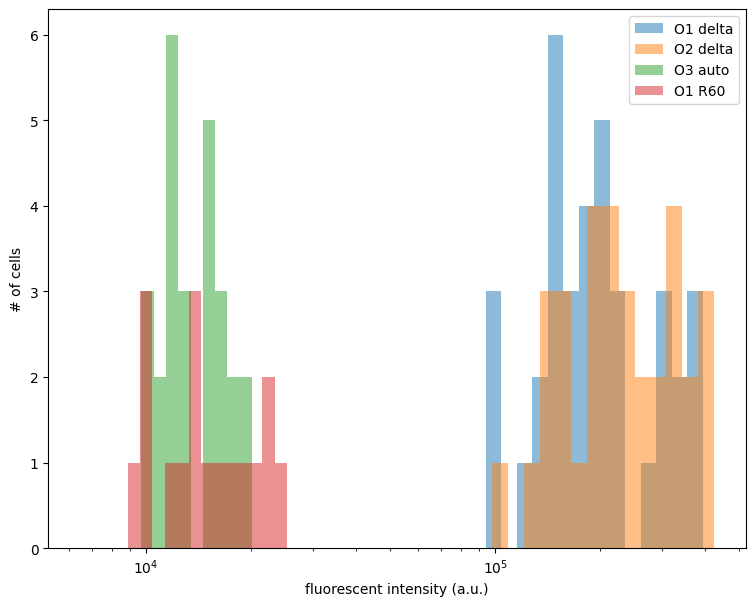

In [ ]:
phase_files = ["O1_delta_phase_pos_01.tif", "O2_delta_phase_pos_01.tif", "O3_auto_phase_pos_01.tif", "O1_R60_phase_pos_01.tif"]
fluor_files = ["O1_delta_yfp_pos_01.tif", "O2_delta_yfp_pos_01.tif", "O3_auto_yfp_pos_01.tif", "O1_R60_yfp_pos_01.tif"]
labels = ['O1 delta','O2 delta', 'O3 auto', 'O1 R60' ]

fig, ax = plt.subplots(figsize=(9,7))

# set up plot environment

ax.set_xscale('log')
ax.set_xlabel('fluorescent intensity (a.u.)')
ax.set_ylabel('# of cells')

for i in range(len(phase_files)):
  test_phase = skimage.io.imread(image_dir + phase_files[i])
  test_fluor = skimage.io.imread(image_dir + fluor_files[i])
  intensity = extract_intensities(test_phase, test_fluor)

  num_bins = 15

  # need to compute special bins for logscale on x axis
  lower_bound = np.log10(intensity.min())
  upper_bound = np.log10(intensity.max())
  hist_bins = np.logspace(lower_bound, upper_bound, num_bins)
  ax.hist(intensity, bins=hist_bins,
          alpha=0.5, label = labels[i])
  ax.legend();

## Question 1e

I will define a function strain_totals which takes in two parameters, the operator and the repressor copy number. I will use glob to get all phase contrast images and their associated fluorescence images with the corresponding operator and repressor copy number for each position. Next, I will read images from a single cell, and use the function extract_intensities from 1d to get a list of single-cell intensities. Then, I will append the single-cell ints into one list and finally return a list of intensities for all cells.

In [ ]:
def strain_totals(op, rep):
  phase_names = np.sort(glob.glob(image_dir + op + '_' 
                                    + rep + '_phase*.tif'))
  fluor_names = np.sort(glob.glob(image_dir + op + '_' 
                                    + rep + '_yfp*.tif'))

  # Set up a storage vector to hold the single-cell intensities.
  strain_intensities = []
  #loop through image files
  for k in range(len(phase_names)):
      #read phase and fluor images
      im_phase = skimage.io.imread(phase_names[k])
      im_fluor = skimage.io.imread(fluor_names[k])
      #use the mask to compute fluorescent intensities for all segmented cells
      intensities = extract_intensities(im_phase, im_fluor)
      #append the computed intensity value to the list 
      for val in intensities:
          strain_intensities.append(val)

  return strain_intensities

To visualize the intensities of the strains, I will plot histograms for the four specified strains, the O1 auto, O2 auto, O2 delta, and O3 delta. The histograms show a Gaussian distribution of intensity values. The intensity values on average for the delta strains are higher than the intensity values for the auto strains, which is reasonable because the delta strains have 0 repressors and therefore more genes are expressed, leading to a higher level of fluorescence. On the other hand, the auto strains are where the fluorescent gene of interest is removed entirely, so there is only a low level of autofluorescence. The operators are the regions where the repressor itself binds, and different operators have different ∆εr, which explains the different intensity values of O1, O2 and O3 strains. 

There are a
few outliers on the high intensity side, especially for the delta strains. 

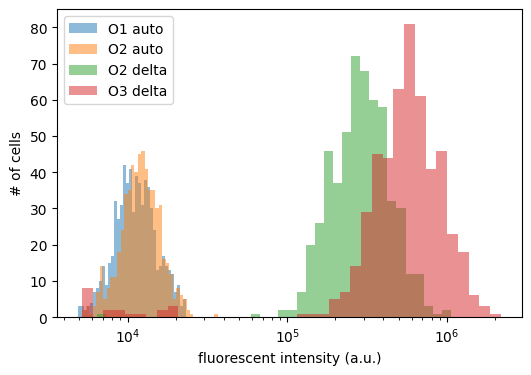

In [ ]:
strain_intensities = []
labels = ["O1 auto", "O2 auto", "O2 delta", "O3 delta"]

#calculate intensities for specified strains
O1_auto = strain_totals("O1", "auto")
O2_auto = strain_totals("O2", "auto")
O2_delta = strain_totals("O2", "delta")
O3_delta = strain_totals("O3", "delta")

#append to empty array storing 
strain_intensities.append(O1_auto)
strain_intensities.append(O2_auto)
strain_intensities.append(O2_delta)
strain_intensities.append(O3_delta)

# set up plot environment
fig, ax = plt.subplots(figsize=(6,4))
ax.set_xscale('log')
ax.set_xlabel('fluorescent intensity (a.u.)')
ax.set_ylabel('# of cells')
# loop over strain intesities array
for i in range(len(strain_intensities)):
    strain_int_list = np.asarray(strain_intensities[i])
    # need to compute special bins for logscale on x axis
    num_bins = 40
    lower_bound = np.log10(strain_int_list.min())
    upper_bound = np.log10(strain_int_list.max())
    hist_bins = np.logspace(lower_bound, upper_bound, num_bins)

    # plot histogram of intensities for each strain
    ax.hist(strain_int_list, bins=hist_bins,
            alpha=0.5, label=labels[i])
    ax.legend();

## Question 1f

To compute the mean fluorescent intensity for all provided strains, I will define three arrays storing the operators, the repressor names and their copy numbers.
I will define a function to calculate the fold change from microscopy data, which populates a 2D array where the value at cell i, j corresponds to the fold change of operator i with repressor copy number j. 

 Next I will loop over the operators and compute the mean auto and delta fluorescent intensity values using the strain_totals() function earlier. Given the empirical formula for fold change = = ⟨I R\neq0⟩ − ⟨Iauto⟩/
⟨Idelta⟩ − ⟨Iauto⟩, where I is the average intensity over all cells in all images for that particular strain, I will calculate the fold-change by taking the values from the mean intensities 2D array, subtract off the autofluorescence as specified in Equation 2, and return the array of fold changes.

In [ ]:
 # predefine name arrays
ops = ['O1', 'O2', 'O3']
rep_names = ['R22', 'R60', 'R124', 'R260']
rep_nums = [22, 60, 124, 260]

def calc_fold_change_micro():
  """Plot fold change of microscropy data"""
  # preallocation of fold_change_table
  mean_intens_micro = np.zeros((len(ops), len(rep_names)))
  fc_micro = np.zeros(((len(ops), len(rep_names))))

  #loop over indices in array
  for ii in range(len(ops)):
    #get the operator name
    op = ops[ii]

    #find autoflorescence value
    auto_inten = np.mean(strain_totals(op, 'auto'))

    #find delta fluorescence value 
    delta_inten = np.mean(strain_totals(op, 'delta'))

    #loop over repressor copy number to populate the rows
    for j in range(len(rep_names)):
      repressor = rep_names[j];
      mean_intens_micro[ii, j] = np.mean(strain_totals(op, repressor)) 

      #fold_change at the ith strain and jth copy number
      fc_micro[ii, j] = (mean_intens_micro[ii, j] - auto_inten)/ (delta_inten - auto_inten)

  return fc_micro



In [ ]:
fc_micro = calc_fold_change_micro()

## Question 1g

I will replot the prediction curves but now with the fold-change results from the microscopy data. I see the data points fit the predictions reasonably well, with the exception of a few data points. From examining the mean flurescent intensity array, I see that most intensity values follow the trend where the larger the number of repressors there are, the less the gene is expressed and therefore the lower the intensity value. However, there are some outliers in the intesities. One possible reason is that expression levels are highly variable across strains. A possible experimental reason is due to outside lighting conditions when the images are captured that cause the intensity values to be miscalculated. Another computational reason can be the threshold fails to capture some bacterias and therefore those pixels are not accounted in the mean intensity calculations. 


In [ ]:
def plot_fold_change_from_micro_data():
  """
  Plot fold change prediction based on operator
  """
  #E coli genome size
  N_ns = 4.6 * 10**6

  #binding energy difference calculated in image
  delta_er_O1 = -15.667
  delta_er_O2 = -14.158
  delta_er_O3 = -9.873

  #set up plot and x axis range
  R = np.arange(1, 1001)
  fig, ax = plt.subplots(figsize = (5, 3))

  fold_change_1 = 1.0 / (1 + (R / N_ns)* math.exp(-1 *  delta_er_O1))
  fold_change_2 = 1.0 / (1 + (R / N_ns)* math.exp(-1 * delta_er_O2 ))
  fold_change_3= 1.0 / (1 + (R / N_ns)* math.exp(-1 * delta_er_O3))

  #plot three fold change predictions for three operators
  plt.plot(R, fold_change_1)
  plt.plot(R, fold_change_2)
  plt.plot(R, fold_change_3)
  
  colors =['blue', 'orange', 'green']
  #plot the provided data points for each operator
  R_vals = [260, 260, 260]
  fc_theory_vals = [2.77*10**(-3), 1.24 *10**(-2), 4.77 * 10**(-1)]
  for i in range(3):
    plt.scatter(R_vals[i], fc_theory_vals[i], color=colors[i])

  #plot points from microscopy data
  for i in range(len(ops)):
    for j in range(len(rep_nums)):
        plt.scatter(rep_nums[j], fc_micro[i][j], color=colors[i])
  

  plt.xscale("log")
  plt.yscale("log")

  #set ticks on the axes
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)

  #Label axes and give plot a title
  plt.title("Fold change prediction from microscopy data")
  plt.xlabel("Repressor copy number", fontsize=10)
  plt.ylabel("Fold change prediction (kbT)", fontsize=10)
  plt.legend(['O1','O2', 'O3'])


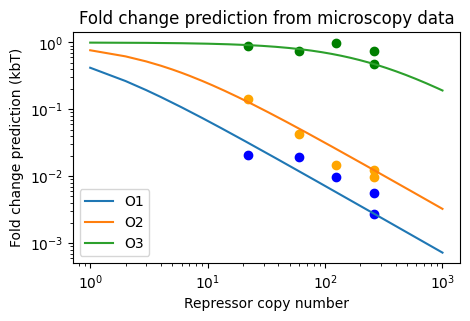

In [ ]:
plot_fold_change_from_micro_data()

## Question 1h

I will define two functions that calculates the predicted fold change given the repressor copy number R and epsilon, a function to take the log of the fold change value, and a function to calculate the binding energy difference given R and the fold change. 

In [ ]:
N_ns = 4.6 * 10**6

def fc_theory(R, epsilon):
  return 1/(1 + R/ N_ns * np.exp(-epsilon))

def log_fcTheory(R, eps):
    return np.log(fc_theory(R, eps))

#calculate delta e
def eps_theory(R, fc):
  return -(np.log(N_ns/R) + np.log(1/fc - 1))

In [ ]:
#load the data
lacZ_df = pd.read_csv('/content/drive/MyDrive/Bi1/lacZ_titration_data.csv', header=8)
lacZ_df

,repressor,fold_change,operator
0,22.42,0.798500,O3
1,59.34,0.652400,O3
2,124.00,0.621000,O3
3,255.30,0.477300,O3
4,22.42,0.175600,O2
5,59.34,0.045190,O2
6,124.00,0.021510,O2
7,255.30,0.012410,O2
8,22.42,0.038860,O1
9,59.34,0.008902,O1


When merely fitting a single point, the values of ∆εr I get are -15.667, -14.158, -9.873, versus from performing least squares to fit all the lacZ data the values of ∆εr I get are -15.776722043610896, -14.170113368518724, -10.046001265092682. The ∆εr are roughly the same, but by using more datapoints the second prediction of ∆εr gives me a more accurate approximation rather than the predictions from a single datum. 



In [ ]:
operators = ['O1', 'O2', 'O3']

#fit epsilon_r for operator
for i in range(len(operators)): 
  #slice repressor row
  r_vals = lacZ_df[lacZ_df['operator'] == operators[i]]['repressor']

  #slice fold change column
  fc_vals_lacZ = np.log(lacZ_df[lacZ_df['operator'] == operators[i]]['fold_change'])

  #as number of repressors increase, fold change decrease
  #returns best guess of parameter and estimate of the error
  fit_param, _ = scipy.optimize.curve_fit(log_fcTheory, r_vals, fc_vals_lacZ)
  print(fit_param[0])


-15.776722043610896
-14.170113368518724
-10.046001265092682


## Question 1i

The infered binding energies for the microscopy data are -15.334747885294352
-14.395320177051703, -8.75261549324254, which are roughly the same compared to the previous lacZ binding energies of -15.776722043610896, -14.170113368518724, -10.046001265092682. The discrepancies could be because any noise in the biological system will have a bigger effect in the lacZ experiment as the fold change are lower than the microscopy data. 

In [ ]:
#fit epsilon_r for operator
for i in range(len(operators)): 
  #slice fold change column
  fc_row_vals = np.log(fc_micro[i])

  #as number of repressors increase, fold change decrease
  #returns best guess of parameter and estimate of the error
  fit_param, _ = scipy.optimize.curve_fit(log_fcTheory, rep_nums, fc_row_vals)
  print(fit_param[0])


-15.334747885294352
-14.395320177051703
-8.75261549324254


## Question 1j

To plot the theory curves, I will first store the predicted ∆εr’s for each operator in a list, and pass the respective ∆εr to the fc_theory function to get the theoretical fold change values. I will use these values to plot the theory curves for O1, O2, and O3 strains using plt.plot(). To plot the lacZ datapoints, I will get the x and y coordinates corresponding to the repressor copy number and operator from the dataframe, and call plt.scatter(). For plotting experimental microscopy data, I will loop through the 2D array storing fold change calculations of microscopy data from earlier. I also included labels for different types of curves and datapoints to display in the legend. 

I observe from the graph that the data points follow the general trend of the theory curve. There is some discrepancy which can be explained by the simplication of the model. To better test the model, we will need more experiments with higher R values. 


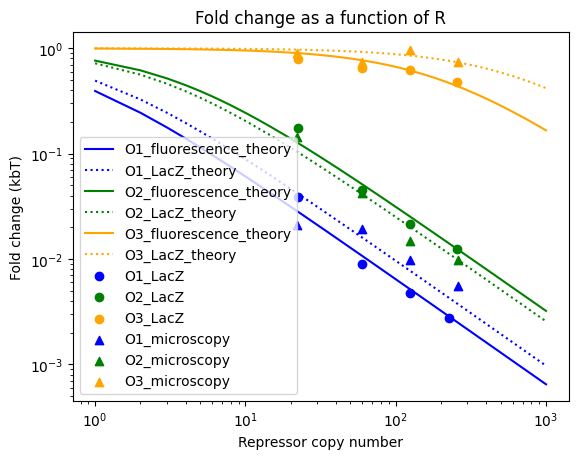

In [ ]:
reps = [22, 60, 124, 260]
colors = ['blue', 'green', 'orange']
N_ns = 4.6 * 10**6

#set up x axis range
fig, ax = plt.subplots()
R = np.arange(1, 1001)

#declare list of binding energies
delta_er_from_fluor = [-15.776722043610896, -14.170113368518724, -10.046001265092682]
delta_er_from_lacZ = [-15.37024885253724, -14.398648089890724, -8.764941873823465]

#plot theory curves
for i in range(3):
  fold_change_from_fluor = fc_theory(R, delta_er_from_fluor[i])
  plt.plot(R, fold_change_from_fluor, color=colors[i], label= operators[i] + "_fluorescence_theory")
  fold_change_from_lacZ = fc_theory(R, delta_er_from_lacZ[i])
  plt.plot(R, fold_change_from_lacZ, color=colors[i], label=operators[i] + "_LacZ_theory", linestyle='dotted')


#plot lacZ datapoints
for i in range(len(operators)): 
  #slice repressor row
  r_vals = lacZ_df[lacZ_df['operator'] == operators[i]]['repressor']
  #slice fold change column
  fc_vals_lacZ = lacZ_df[lacZ_df['operator'] == operators[i]]['fold_change']
  plt.scatter(r_vals, fc_vals_lacZ, color=colors[i],  marker='o', label=operators[i]+ "_LacZ")

#plot microscopy datapoints
for i in range(len(ops)):
    plt.scatter(rep_nums, fc_micro[i], color=colors[i],  marker='^', label= operators[i] + "_microscopy")


plt.xscale("log")
plt.yscale("log")

plt.title("Fold change as a function of R")
plt.xlabel("Repressor copy number", fontsize=10)
plt.ylabel("Fold change (kbT)", fontsize=10)
plt.legend()


---

### Submission instructions

When you're finished, recall the steps for submitting Colab notebooks:

1. Run all the cells from top-to-bottom, in order (`Runtime` > `Run all`).
2. Once the entire notebook has completed running and the output of all cells is visible, save it (`File` > `Save`).
3. Download the notebook in `.ipynb` format (`File` > `Download` > `Download .ipynb`).
4. Rename the file according to the usual convention (`lastname_firstname_hw#.ipynb`), if you haven't already.
5. Upload the file to Canvas.
